In [1]:
import zipfile
from PIL import Image
import io
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import random

global_image_dim = 180

2024-04-30 18:01:20.093175: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 18:01:20.289340: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 18:01:21.146527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load Datasets

In [2]:
high_path = './high-quality'
low_path = './low-quality'
categories = ['real', 'fake']

data_high = []
data_low = []

data_low_img = []
data_low_label = []

for category in categories:
    high_folder_path = os.path.join(high_path, category)
    low_folder_path = os.path.join(low_path, category)
    label = 1 if category == 'real' else 0

    for file in os.listdir(high_folder_path):
        if file.endswith(('jpg', 'png', 'jpeg')):  
            file_path = os.path.join(high_folder_path, file)
            image = Image.open(file_path)
            data_high.append((image, label))
            
    for file in os.listdir(low_folder_path):
        if file.endswith(('jpg', 'png', 'jpeg')):  
            file_path = os.path.join(low_folder_path, file)
            image = Image.open(file_path)
            data_low_img.append(image)
            data_low_label.append(label)
            data_low.append((image, label))

## Show data examples : High quality 

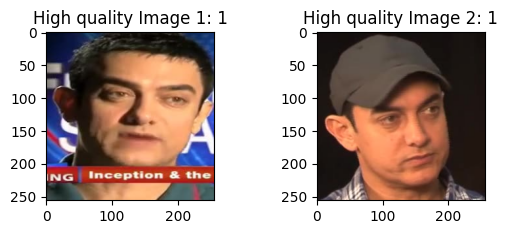

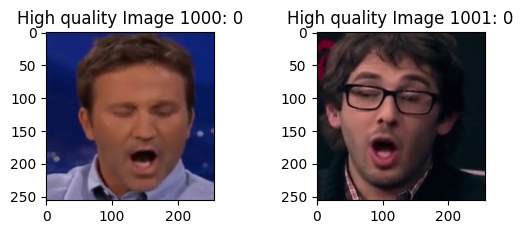

In [3]:

# Hight qulity 1 means real, 0 means fake

plt.subplot(2, 2, 1)  
plt.imshow(data_high[0][0], cmap='gray') 
plt.title(f'High quality Image 1: { data_high[0][1] }') 

plt.subplot(2, 2, 2) 
plt.imshow(data_high[1][0], cmap='gray')  
plt.title(f'High quality Image 2: { data_high[1][1] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_high[1000][0], cmap='gray') 
plt.title(f'High quality Image 1000: { data_high[1000][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_high[1001][0], cmap='gray')  
plt.title(f'High quality Image 1001: { data_high[1001][1] }') 
plt.show() 

## Show data examples : Low quality 

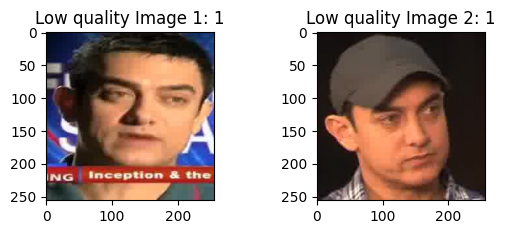

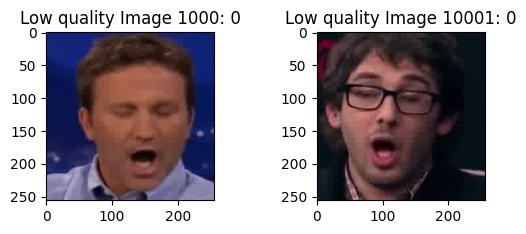

In [4]:
# Low qulity 1 means real, 0 means fake

plt.subplot(2, 2, 1)  
plt.imshow(data_low[0][0], cmap='gray') 
plt.title(f'Low quality Image 1: { data_low[0][1] }') 

plt.subplot(2, 2, 2) 
plt.imshow(data_low[1][0], cmap='gray')  
plt.title(f'Low quality Image 2: { data_low[1][1] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_low[1000][0], cmap='gray') 
plt.title(f'Low quality Image 1000: { data_low[1000][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_low[1001][0], cmap='gray')  
plt.title(f'Low quality Image 10001: { data_low[1001][1] }') 
plt.show() 

# Preprocess with clahe

In [3]:
#The order of elements in the list is disrupted
random.shuffle(data_high)
random.shuffle(data_low)

In [4]:
def build_model_clahe_predictor(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        # predicte: clip_limit & tile_grid_size
        layers.Dense(2, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [10]:
def preprocess_data(data):
    processed_images = []
    labels = []
    for image, label in data:
        # adjust size
        image = np.array(image.resize((global_image_dim, global_image_dim)))
        # Normalization
        image = image.astype(np.float32) / 1.0
        processed_images.append(image)
        labels.append(label)
    return np.array(processed_images), np.array(labels)

processed_high, labels_high = preprocess_data(data_high)
processed_low, labels_low = preprocess_data(data_low)

In [4]:
def apply_clahe(image, clip_limit,tile_grid_size):
    img_np = np.array(image)
    img_np = img_np[:, :, ::-1]  # Convert RGB to BGR
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_BGR2Lab)  # Convert to Lab color space
    l, a, b = cv2.split(img_lab)  # Split into channels
    tile_grid_size_int = int(tile_grid_size)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size_int, tile_grid_size_int))  # Apply CLAHE with specified parameters
    l_clahe = clahe.apply(l)  # Apply to L channel
    lab_clahe = cv2.merge((l_clahe, a, b))  # Merge back the channels
    img_clahe_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2BGR)  # Convert back to BGR
    img_clahe_rgb = img_clahe_bgr[:, :, ::-1]  # Convert BGR to RGB
    return Image.fromarray(img_clahe_rgb)

def apply_clahe_numpy(img_np,  clip_limit, tile_grid_size):
    img_np = img_np[:, :, ::-1]  # Convert RGB to BGR    
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_BGR2Lab)  # Convert to Lab color space
    l, a, b = cv2.split(img_lab)  # Split into channels
    tile_grid_size_int = int(tile_grid_size)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_grid_size_int, tile_grid_size_int))  # Apply CLAHE with specified parameters
    l_clahe = clahe.apply(l)  # Apply to L channel
    lab_clahe = cv2.merge((l_clahe, a, b))  # Merge back the channels
    img_clahe_bgr = cv2.cvtColor(lab_clahe, cv2.COLOR_Lab2BGR)  # Convert back to BGR
    img_clahe_rgb = img_clahe_bgr[:, :, ::-1]  # Convert BGR to RGB
    return img_clahe_rgb

def apply_merged_clahe(image, clip_limit, tile_grid_size):
    border = tile_grid_size // 2
    
    img_br = cv2.copyMakeBorder(np.array(image), border, 0, border, 0, cv2.BORDER_CONSTANT)
    img_br = apply_clahe_numpy(img_br, clip_limit, tile_grid_size)
    img_br = img_br[border:, border:]

    img_bl = cv2.copyMakeBorder(np.array(image), border, 0, 0, border, cv2.BORDER_CONSTANT)
    img_bl = apply_clahe_numpy(img_bl, clip_limit, tile_grid_size)
    img_bl = img_bl[border:, :-border]

    img_tr = cv2.copyMakeBorder(np.array(image), 0, border, border, 0, cv2.BORDER_CONSTANT)
    img_tr = apply_clahe_numpy(img_tr, clip_limit, tile_grid_size)
    img_tr = img_tr[:-border, border:]

    img_tl = cv2.copyMakeBorder(np.array(image), 0, border, 0, border, cv2.BORDER_CONSTANT)
    img_tl = apply_clahe_numpy(img_tl, clip_limit, tile_grid_size)
    img_tl = img_tl[:-border, :-border]
    
    img = np.array(image)
    img = apply_clahe_numpy(img, clip_limit, tile_grid_size)
    img_mixed = ((img_tl / 5) + (img_tr / 5) + (img_bl / 5) + (img_br / 5) + (img / 5)   ).astype(np.uint8)
    
    return Image.fromarray(img_mixed)

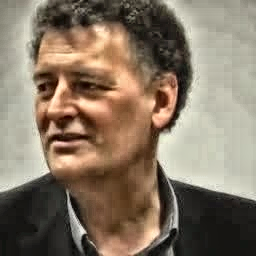

In [7]:
data_high[3][0]
apply_clahe(data_high[3][0], 5, 15)
apply_merged_clahe(data_high[3][0], 4, 15)

In [8]:
def enhance_images(data,clip_limit,tile_grid_size):
    enhanced_images = []
    enhanced_images_label = []
    for i in range(len(data)):
        enhanced_image = apply_clahe(data[i][0], clip_limit,tile_grid_size)
        enhanced_images.append(enhanced_image)
        enhanced_images_label.append(data[i][1])
    return enhanced_images,enhanced_images_label

# enhanced_images_high,enhanced_high_label = enhance_images(data_high,15,7)
# enhanced_images_low,enhanced_low_label = enhance_images(data_low,15,7)

# Get CLAHE parameters : clip_limit, tile_grid_size

/home/ivans/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


I0000 00:00:1714453070.061427     786 service.cc:145] XLA service 0x7f2ce0078200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714453070.062053     786 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-04-30 16:57:50.100292: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 7/44 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 790065.1875 - mae: 468.3685

I0000 00:00:1714453073.310133     786 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - loss: 263201.9375 - mae: 167.0918 - val_loss: 8.0588 - val_mae: 2.0614
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.7725 - mae: 1.7661 - val_loss: 6.2966 - val_mae: 1.8123
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.2855 - mae: 1.5210 - val_loss: 6.9878 - val_mae: 1.8263
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.9724 - mae: 1.4434 - val_loss: 6.5733 - val_mae: 1.8255
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.1759 - mae: 1.3065 - val_loss: 7.6707 - val_mae: 1.8710
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.7479 - mae: 1.2033 - val_loss: 6.4143 - val_mae: 1.7479
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.1813 - mae: 1.0665 - val_loss: 6.2602 - val_mae: 1.7663
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.9222 - mae: 0.9998 - val_loss: 7.1113 - val_mae: 1.8750
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.6570 - 

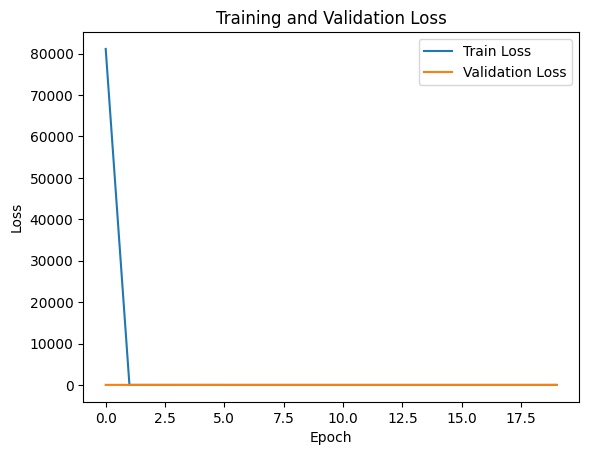

In [27]:
def generate_synthetic_clahe_params(num_samples):
     # Generating machine image brightness index, different illumination conditions
    brightness_levels = np.random.rand(num_samples)
     # Clip_limit according to the calculation of the original brightness, clip_limit according to the demand of the dark image
    clip_limits = 1 + 3 * (1 - brightness_levels) # clip_limit
     # Generating machine coherence index, model dissimilar coherence strength
    texture_levels = np.random.rand(num_samples)
     # Root construction calculation tile_grid_size, calculation construction calculation tile_grid_size, calculation tile_grid_size calculation tile_grid_size
    tile_grid_sizes = 8 + (8 * (1 - texture_levels)).astype(int) # tile_grid_size范围从8到16
    return np.vstack((clip_limits, tile_grid_sizes)).T


x_data = np.array(processed_low)  
num_images = len(processed_low)
y_data = generate_synthetic_clahe_params(num_images)
input_shape = x_data.shape[1:] 
model = build_model_clahe_predictor(input_shape)

# y_data is CLAHE parameters
history = model.fit(x_data, y_data, batch_size=32, epochs=20, validation_split=0.2)
 
loss, accuracy = model.evaluate(x_data, y_data)
y_pred_best_low = model.predict(x_data)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Apply CLAHE

In [5]:
def enhance_images_clahe(data, clip_limit, tile_size, enhance_function):
    enhanced_images = []
    enhanced_images_label = []
    for i in range(len(data)):
        enhanced_image = enhance_function(data[i][0],clip_limit, tile_size)
        enhanced_images.append(enhanced_image)
        enhanced_images_label.append(data[i][1])
    return enhanced_images,enhanced_images_label
    
def enhance_images(data,y_pred_best_low):
    enhanced_images = []
    enhanced_images_label = []
    for i in range(len(data)):
        enhanced_image = apply_clahe(data[i][0],y_pred_best_low[i][0],y_pred_best_low[i][1])
        enhanced_images.append(enhanced_image)
        enhanced_images_label.append(data[i][1])
    return enhanced_images,enhanced_images_label


enhanced_low_standard, enhanced_low_standard_label = enhance_images_clahe(data_low, 3, 15, apply_clahe)
enhanced_low_mixed, enhanced_low_mixed_label = enhance_images_clahe(data_low, 3, 15, apply_merged_clahe)
# enhanced_images_high,enhanced_high_label = enhance_images(data_high,15,7)


# enhanced_images_low,enhanced_low_label = enhance_images(data_low,y_pred_best_low)

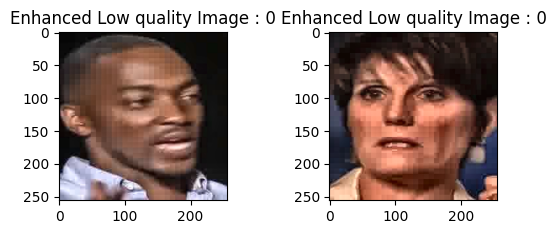

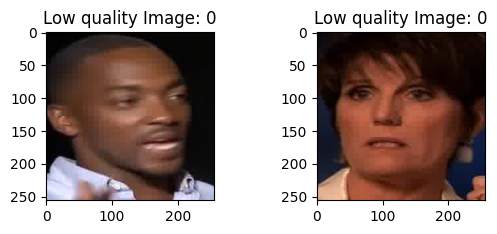

In [13]:
plt.subplot(2, 2, 1)  
plt.imshow(enhanced_images_low[2], cmap='gray') 
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[0] }') 

plt.subplot(2, 2, 2) 
plt.imshow(enhanced_images_low[3], cmap='gray')  
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[1] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(data_low[2][0], cmap='gray') 
plt.title(f'Low quality Image: { data_low[0][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(data_low[3][0], cmap='gray')  
plt.title(f'Low quality Image: { data_low[1][1] }') 
plt.show() 


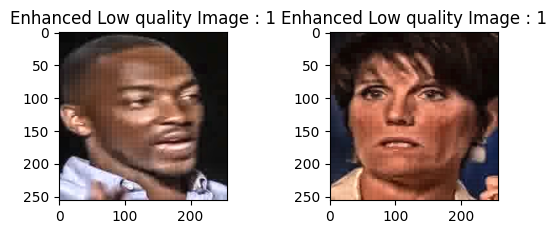

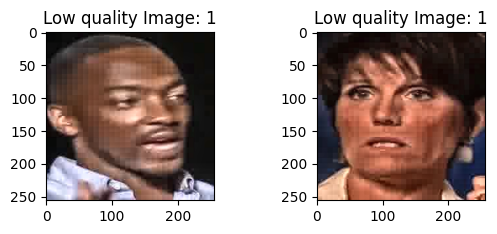

In [14]:
plt.subplot(2, 2, 1)  
plt.imshow(enhanced_low_mixed[2], cmap='gray') 
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[2] }') 

plt.subplot(2, 2, 2) 
plt.imshow(enhanced_low_mixed[3], cmap='gray')  
plt.title(f'Enhanced Low quality Image : { enhanced_low_label[3] }') 
plt.show() 

plt.subplot(2, 2, 3)  
plt.imshow(enhanced_low_standard[2], cmap='gray') 
plt.title(f'Low quality Image: { data_low[2][1] }') 

plt.subplot(2, 2, 4) 
plt.imshow(enhanced_low_standard[3], cmap='gray')  
plt.title(f'Low quality Image: { data_low[3][1] }') 
plt.show() 

# Build Model

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

def build_model(input_shape):

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)  

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def get_model(num_classes = 2):
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(global_image_dim,
                                      global_image_dim,
                                      3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )

    model = Sequential([
          data_augmentation,
          layers.Rescaling(1./255),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(128, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(256, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(256, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Dropout(0.2),
          layers.Flatten(),
          layers.Dense(256, activation='relu'),
          layers.Dense(num_classes, name="outputs")
        ])

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    # input_shape = (global_image_dim, global_image_dim, 3)  
    # model = build_model(input_shape)
    return model

model = get_model()

# Train Model on low quality enhanced images

In [19]:
def preprocess_data_after(enhanced_images):
    processed_images = []
    for image in enhanced_images:
        image = np.array(image.resize((global_image_dim, global_image_dim)))
        # Normalization
        image = image.astype(np.float32)
        processed_images.append(image)
    return np.array(processed_images)

In [20]:
# X_low = preprocess_data_after(enhanced_images_low)
# y_low = np.array(enhanced_low_label)
X_low_std = preprocess_data_after(enhanced_low_standard)
y_low_std = np.array(enhanced_low_standard_label)
X_low_mix = preprocess_data_after(enhanced_low_mixed)
y_low_mix = np.array(enhanced_low_mixed_label)
print(X_low_std.shape)
print(y_low_std.shape)

(1727, 180, 180, 3)
(1727,)


In [21]:
# X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, test_size=0.2) #enhanced
X_train_low_std, X_test_low_std, y_train_low_std, y_test_low_std = train_test_split(X_low_std, y_low_std, test_size=0.2) #enhanced
X_train_low_mix, X_test_low_mix, y_train_low_mix, y_test_low_mix = train_test_split(X_low_mix, y_low_mix, test_size=0.2) #enhanced
X_train_low_raw, X_test_low_raw, y_train_low_raw, y_test_low_raw = train_test_split(processed_low, labels_low, test_size=0.2) #raw

In [22]:
print(X_train_low_mix.shape)
print(X_train_low_raw.shape)

(1381, 180, 180, 3)
(1381, 180, 180, 3)


In [23]:
def train_and_evaluate_model_raw(X_train, y_train, X_test, y_test, batch_size=32, epochs=20):
    model = get_model()
    model.summary()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
    return model

def train_and_evaluate(X_train, y_train, X_test, y_test, batch_size=32, epochs=100):
    model = get_model()
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size=batch_size, epochs=epochs)
    
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, batch_size=16, epochs=100):
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

model = build_model(input_shape=(global_image_dim,global_image_dim, 3))

/tmp/ipykernel_4973/3028342261.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


In [16]:
train_and_evaluate(X_train_low,y_train_low,X_test_low,  y_test_low)

NameError: name 'X_train_low' is not defined

# Train Model on low quality raw images

In [ ]:
train_and_evaluate(X_train_low_raw, y_train_low_raw,X_test_low_raw, y_test_low_raw,epochs=50)

Epoch 1/50


2024-04-30 18:08:45.966636: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_11_1/dropout_8_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.5320 - loss: 0.7738 - val_accuracy: 0.4855 - val_loss: 0.6945
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5204 - loss: 0.6923 - val_accuracy: 0.4884 - val_loss: 0.6857
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5295 - loss: 0.6932 - val_accuracy: 0.5289 - val_loss: 0.6788
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5575 - loss: 0.6821 - val_accuracy: 0.5145 - val_loss: 0.6883
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5751 - loss: 0.6745 - val_accuracy: 0.6792 - val_loss: 0.6355
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6972 - loss: 0.6107 - val_accuracy: 0.7514 - val_loss: 0.4954
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.7447 - loss: 0.5272 - val_accuracy: 0.7919 - val_loss: 0.4647
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.7719 - loss: 0.5032 - val_accuracy: 0.8266 - val_loss: 0

Epoch 1/40


2024-04-30 17:21:13.573344: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_17_1/dropout_11_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.5076 - loss: 0.7278 - val_accuracy: 0.4364 - val_loss: 0.6971
Epoch 2/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.5359 - loss: 0.6925 - val_accuracy: 0.4364 - val_loss: 0.6947
Epoch 3/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.5024 - loss: 0.6931 - val_accuracy: 0.4364 - val_loss: 0.7133
Epoch 4/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.4981 - loss: 0.6933 - val_accuracy: 0.5809 - val_loss: 0.6870
Epoch 5/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5346 - loss: 0.6896 - val_accuracy: 0.7514 - val_loss: 0.5766
Epoch 6/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6813 - loss: 0.6051 - val_accuracy: 0.8064 - val_loss: 0.4797
Epoch 7/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.7618 - loss: 0.5150 - val_accuracy: 0.8064 - val_loss: 0.4267
Epoch 8/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.7843 - loss: 0.4718 - val_accuracy: 0.8468 - val_loss: 0.

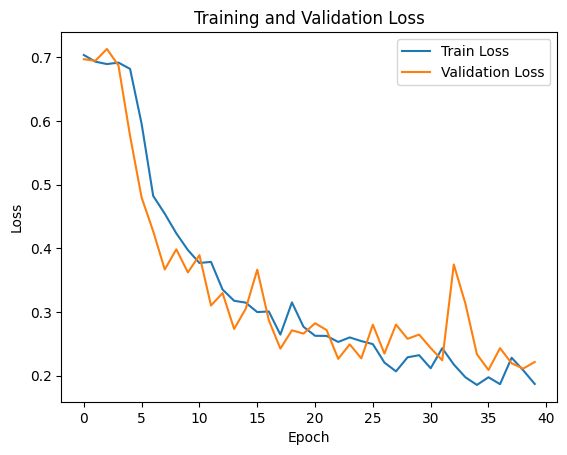

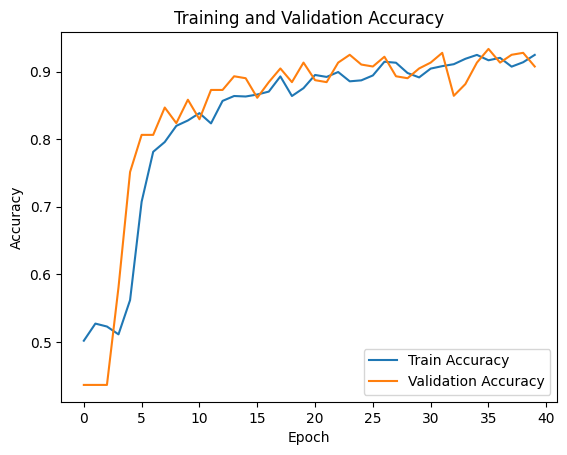

In [28]:
train_and_evaluate(X_train_low_std,y_train_low_std,X_test_low_std,  y_test_low_std, epochs=40)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.4888 - loss: 0.7337 - val_accuracy: 0.4827 - val_loss: 0.6933
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.4902 - loss: 0.6932 - val_accuracy: 0.4827 - val_loss: 0.6933
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5019 - loss: 0.6932 - val_accuracy: 0.5173 - val_loss: 0.6928
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.5086 - loss: 0.6932 - val_accuracy: 0.5173 - val_loss: 0.6814
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5551 - loss: 0.6791 - val_accuracy: 0.7803 - val_loss: 0.5160
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7275 - loss: 0.5453 - val_accuracy: 0.8006 - val_loss: 0.4520
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7619 - loss: 0.5192 - val_accuracy: 0.8237 - val_loss: 0.4042
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7949 - loss: 0.4735 - val_accuracy: 0.8410 - v

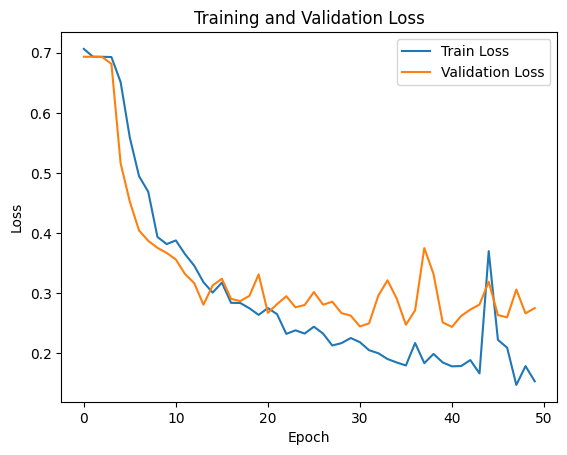

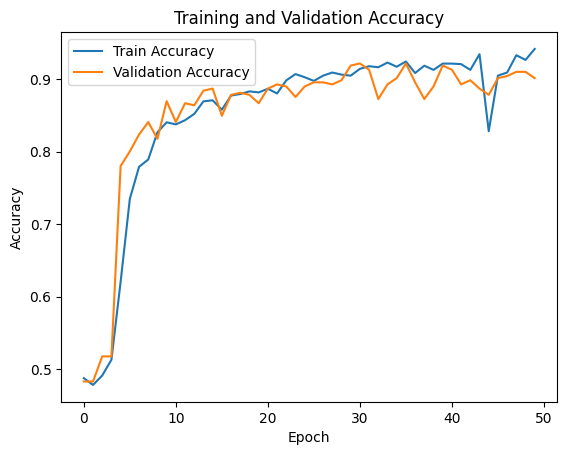

In [31]:
train_and_evaluate(X_train_low_mix,y_train_low_mix,X_test_low_mix,  y_test_low_mix, epochs=50)

# Train Model on high quality processed images

# Train Model on high quality raw images

In [10]:
random.shuffle(data_low)

In [11]:
def run_and_predict(data, clip_limit_low, clip_limit_high, window_size):
    split_ratio = 2
    data_len = len(data)
    chunk = data_len // split_ratio
    res = {}
    stored_train = {}
    for clip_limit in range(clip_limit_low, clip_limit_high + 1):
        res[clip_limit] = []
        stored_train[clip_limit] = None
        
    for i in range(split_ratio):
        for clip_limit in range(clip_limit_low, clip_limit_high + 1):
            stored_train[clip_limit] = None
        val = data[int(i * chunk):int((i+1) * chunk)]
        train = data[:int(i * chunk)] + data[int((i+1) * chunk):]
        print("VT", len(val), len(train), data_len, chunk)
        X_train = None
        y_train = None
        X_test = None
        y_test = None
        for clip_limit in range(clip_limit_low, clip_limit_high + 1):
            X_train_cl, y_train_cl = enhance_images_clahe(train, 3 + clip_limit * 3, window_size, apply_clahe)
            X_test_cl, y_test_cl = enhance_images_clahe(val, 3 + clip_limit * 3, window_size, apply_clahe)
            X_train_cl = preprocess_data_after(X_train_cl)
            X_test_cl = preprocess_data_after(X_test_cl)
            y_train_cl = np.array(y_train_cl)
            y_test_cl = np.array(y_test_cl)
            if(X_train is None):
                X_train = X_train_cl
            else:
                X_train = np.concatenate((X_train, X_train_cl))

            if(y_train is None):
                y_train = y_train_cl
            else:
                y_train = np.concatenate((y_train, y_train_cl))

            if(X_test is None):
                X_test = X_test_cl
            else:
                X_test = np.concatenate((X_test, X_test_cl))

            if(y_test is None):
                y_test = y_test_cl
            else:
                y_test = np.concatenate((y_test, y_test_cl))

            if(stored_train[clip_limit] is None):
                stored_train[clip_limit] = X_train_cl
            else:
                stored_train[clip_limit] = np.concatenate((stored_train[clip_limit], X_train_cl))

            # for x in X_train:
            #     stored_train[clip_limit].append(x) 
        print(len(X_train), len(y_train), len(X_test), len(y_test))
        model = train_and_evaluate_model_raw(X_train, y_train, X_test, y_test)
        for clip_limit in range(clip_limit_low, clip_limit_high + 1):
            tempRes = model.predict(stored_train[clip_limit])
            for x in tempRes:
                res[clip_limit].append(x)
    return res

clip_low = 0
clip_high = 2
clips = list(range(clip_low, clip_high + 1))

data_clipped = data_low[:1000]
outp = run_and_predict(data_clipped, clip_low,clip_high,15)
best_clips = []
for i in range(len(data_clipped)):
    best_clip = -1
    best_value = -1
    cur_label = data_clipped[i][1]
    for clip_limit in outp.keys():
        if outp[clip_limit][i][cur_label] > best_value:
            best_value = outp[clip_limit][i][cur_label]
            best_clip = clip_limit
    best_clips.append(best_clip-3)            

VT 500 500 1000 500
1500 1500 1500 1500
Epoch 1/20


I0000 00:00:1714392307.441874   20378 service.cc:145] XLA service 0x7fd998003e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714392307.442015   20378 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-04-30 00:05:07.578328: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-30 00:05:08.303662: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1714392310.079992   20467 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4606', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1714392310.852146   20463 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1651', 244 bytes spill stores, 244 bytes spill loads

I0000 0

 4/47 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5853 - loss: 1.1000

I0000 00:00:1714392319.407662   20378 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5687 - loss: 0.9813

I0000 00:00:1714392323.047118   20545 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4606', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1714392323.424526   20539 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1651', 252 bytes spill stores, 252 bytes spill loads



47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.5685 - loss: 0.9781 - val_accuracy: 0.6433 - val_loss: 0.6199
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6061 - loss: 0.7048 - val_accuracy: 0.6960 - val_loss: 0.5813
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7024 - loss: 0.5785 - val_accuracy: 0.7293 - val_loss: 0.5443
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6981 - loss: 0.5629 - val_accuracy: 0.7340 - val_loss: 0.5323
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7460 - loss: 0.5105 - val_accuracy: 0.7500 - val_loss: 0.5110
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7644 - loss: 0.4885 - val_accuracy: 0.7453 - val_loss: 0.5096
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8019 - loss: 0.4394 - val_accuracy: 0.7673 - val_loss: 0.4892
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8052 - loss: 0.4358 - val_accuracy: 0.7573 - val_loss: 

I0000 00:00:1714392387.405342   21534 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1150', 260 bytes spill stores, 260 bytes spill loads



16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 535ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
VT 500 500 1000 500
1500 1500 1500 1500
Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - accuracy: 0.5394 - loss: 0.8921 - val_accuracy: 0.6307 - val_loss: 0.6434
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6508 - loss: 0.6427 - val_accuracy: 0.7087 - val_loss: 0.5845
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7304 - loss: 0.5406 - val_accuracy: 0.7293 - val_loss: 0.5524
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7497 - loss: 0.4948 - val_accuracy: 0.7420 - val_loss: 0.5439
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7893 - loss: 0.4517 - val_accuracy: 0.7513 - val_loss: 0.5231
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7916 - loss: 0.4400 - val_accuracy: 0.7560 - val_loss: 0.5151
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8185 - lo

In [81]:
len(best_clips)

500

In [82]:

print(outp[3][0], outp[4][0], outp[5][0], outp[6][0], data_clipped[0][1])

[0.9082339  0.09176616] [0.934045   0.06595501] [0.9495353  0.05046466] [0.940523   0.05947699] 1


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.2396 - loss: 1.9541 - val_accuracy: 0.3600 - val_loss: 1.3037
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3630 - loss: 1.5479 - val_accuracy: 0.4500 - val_loss: 1.2781
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3339 - loss: 1.4189 - val_accuracy: 0.4100 - val_loss: 1.2844
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3985 - loss: 1.3270 - val_accuracy: 0.4200 - val_loss: 1.2814
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3993 - loss: 1.3384 - val_accuracy: 0.4200 - val_loss: 1.2872
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4304 - loss: 1.2505 - val_accuracy: 0.4600 - val_loss: 1.2772
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3979 - loss: 1.2441 - val_accuracy: 0.3900 - val_loss: 1.2981
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4661 - loss: 1.1934 - val_accuracy: 0.4600 -

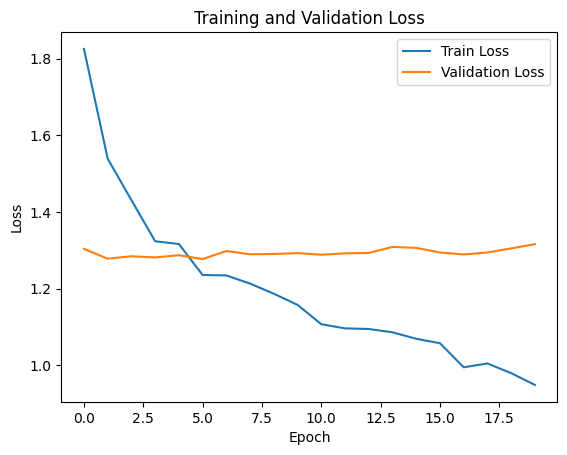

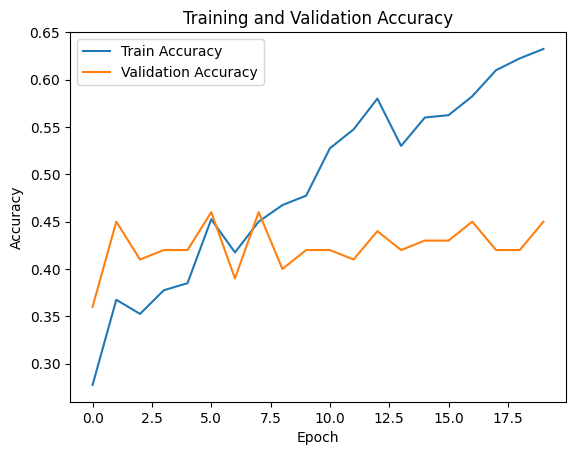

In [85]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
def build_model_clip(input_shape, clip_amount):

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    base_model.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(clip_amount, activation='softmax')(x)  

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def get_model_clip(clip_amount):
    # model = Sequential([
    #   layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    #   layers.Conv2D(16, 3, padding='same', activation='relu'),
    #   layers.MaxPooling2D(),
    #   layers.Conv2D(32, 3, padding='same', activation='relu'),
    #   layers.MaxPooling2D(),
    #   layers.Conv2D(64, 3, padding='same', activation='relu'),
    #   layers.MaxPooling2D(),
    #   layers.Flatten(),
    #   layers.Dense(128, activation='relu'),
    #   layers.Dense(clip_amount)
    # ])
    # model.compile(optimizer='adam',
    #           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #           metrics=['accuracy'])
    input_shape = (224, 224, 3)  
    model = build_model_clip(input_shape, clip_amount)
    return model

model_clip = get_model_clip(len(clips))
# X_clip_img_raw = [x[0] for x in data_clipped]
X_clip_img_raw, ___ = enhance_images_clahe(data_clipped, 0.01, 15, apply_clahe)
X_clip_img = preprocess_data_after(X_clip_img_raw)
y_clip = np.array(best_clips)
X_train_clip, X_test_clip, y_train_clip, y_test_clip = train_test_split(X_clip_img, y_clip, test_size=0.2) #enhanced
train_and_evaluate_model(get_model_clip(len(clips)),X_train_clip,y_train_clip, X_test_clip, y_test_clip, epochs = 20)
# history = model.fit(
#   X_train_clip, y_train_clip,
#   validation_data=(X_test_clip, y_test_clip),
#   epochs=10
# )


In [78]:
print(y_train_clip)

[1 3 1 3 1 1 4 1 1 4 4 2 4 1 2 1 1 4 1 2 1 1 1 1 3 4 4 4 4 1 2 4 1 1 3 4 4
 1 1 4 2 1 1 1 1 2 1 4 4 1 1 1 4 3 1 3 1 4 3 2 3 3 2 4 4 4 1 4 1 4 4 4 1 1
 1 4 4 4 4 2 3 4 1 1 4 4 4 3 1 3 4 2 4 3 4 1 1 1 4 2 1 1 1 1 4 2 1 1 3 1 1
 1 3 4 1 4 3 3 1 4 3 3 4 4 4 2 4 4 1 1 1 3 4 3 4 3 2 1 3 4 4 1 1 4 2 4 4 1
 4 3 4 1 4 2 2 1 4 4 4 2 1 2 1 4 2 4 4 1 4 1 3 1 1 3 1 1 4 4 3 1 3 2 4 2 2
 4 3 1 1 1 2 4 4 4 2 4 4 2 4 4 1 1 1 4 3 1 1 2 1 1 4 1 1 2 1 1 4 1 1 1 2 4
 1 2 4 4 1 4 2 1 3 1 4 2 4 3 1 1 4 3 2 4 4 3 2 3 1 1 1 3 3 3 1 1 1 1 4 1 1
 1 3 4 2 3 1 1 1 3 2 4 2 1 3 4 1 3 4 1 3 4 1 1 4 4 4 4 1 2 2 2 4 4 2 4 4 1
 1 1 2 2 3 1 1 1 1 1 3 4 4 4 4 4 4 2 4 2 1 4 3 1 4 1 1 4 3 4 2 1 2 2 3 1 1
 1 2 4 1 4 4 4 2 1 2 1 4 2 2 2 4 4 2 3 2 1 3 3 1 2 1 1 1 4 4 4 3 1 4 4 4 3
 3 2 4 4 4 1 1 1 4 1 4 4 2 3 3 1 4 4 1 1 1 1 2 2 1 2 1 1 1 4]
